<a href="https://colab.research.google.com/github/cleitonmoya/CPS765_Trabalho2/blob/main/CPS765_Trab2_AnaliseCleiton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rede da Correlação da Covid-19 nos Municípios Brasileiros

In [1]:
!pip install geopandas
import numpy as np
import networkx as nx
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import random
import seaborn as sns

     |████████████████████████████████| 972kB 3.0MB/s 
     |████████████████████████████████| 14.8MB 270kB/s 
     |████████████████████████████████| 6.5MB 31.1MB/s 


Importação das redes:

In [2]:
!wget 'https://raw.githubusercontent.com/cleitonmoya/CPS765_Trabalho2/main/redes/G085.graphml'
!wget 'https://raw.githubusercontent.com/cleitonmoya/CPS765_Trabalho2/main/redes/S085.graphml'
G = nx.read_graphml('G085.graphml', node_type=int) # Rede completa
S = nx.read_graphml('S085.graphml', node_type=int) # Componente conexa

--2021-01-12 13:00:26--  https://raw.githubusercontent.com/cleitonmoya/CPS765_Trabalho2/main/redes/G085.graphml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5876039 (5.6M) [text/plain]
Saving to: ‘G085.graphml’

G085.graphml        100%[===================>]   5.60M  23.7MB/s    in 0.2s    

2021-01-12 13:00:27 (23.7 MB/s) - ‘G085.graphml’ saved [5876039/5876039]

--2021-01-12 13:00:27--  https://raw.githubusercontent.com/cleitonmoya/CPS765_Trabalho2/main/redes/S085.graphml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4994200 (4.8M) [

Base de dados de casos novos:

In [3]:
df_cn = pd.read_csv('https://raw.githubusercontent.com/cleitonmoya/CPS765_Trabalho2/main/datasets/df_cn_mm7.csv', index_col=0, parse_dates=True)

Base de dados dos municípios:

In [4]:
df_mun = pd.read_csv('https://raw.githubusercontent.com/cleitonmoya/CPS765_Trabalho2/main/datasets/municipios.csv', index_col=0, sep=';')

# 1 Análise da rede das capitais

## 1.0 Visualização

### 1.0.1 Capitais x Capitais

In [130]:
df_mun

,regiao,uf,city,capital,population,idhf,pib,latitude,longitude,porte_pop,porte_idh,porte_pib
cod,,,,,,,,,,,,
1100015,Norte,RO,Alta Floresta D'Oeste,False,22728,0.609139,19611.75,-11.92830,-61.9953,3,2,2
1100023,Norte,RO,Ariquemes,False,109523,0.753049,21389.67,-9.90571,-63.0325,6,3,2
1100031,Norte,RO,Cabixi,False,5188,0.591030,22315.80,-13.49450,-60.5520,2,2,2
1100049,Norte,RO,Cacoal,False,85893,0.748255,24037.91,-11.43430,-61.4562,5,3,2
1100056,Norte,RO,Cerejeiras,False,16204,0.663645,25009.71,-13.18700,-60.8168,3,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
5222005,Centro-oeste,GO,Vianópolis,False,13977,0.677555,28942.36,-16.74050,-48.5159,3,2,2
5222054,Centro-oeste,GO,Vicentinópolis,False,8873,0.664198,41772.71,-17.73220,-49.8047,2,2,2
5222203,Centro-oeste,GO,Vila Boa,False,6312,0.321381,23992.38,-15.03870,-47.0520,2,1,2


/usr/local/lib/python3.6/dist-packages/geopandas/plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


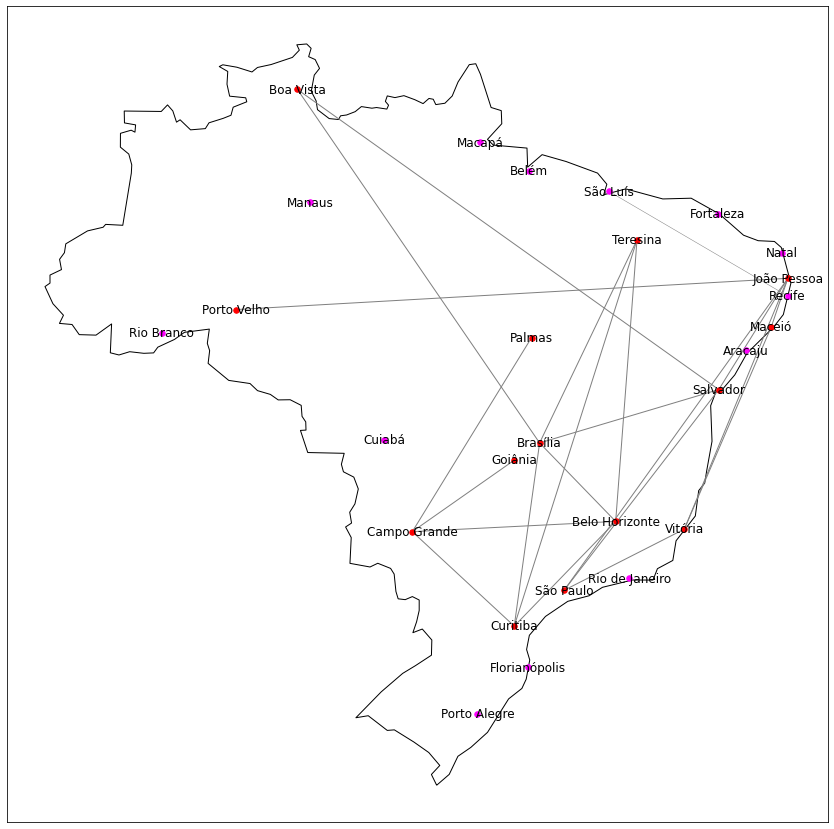

In [5]:
gdf = geopandas.GeoDataFrame()
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# mapa do Brasil.
ax = world[world.name == 'Brazil'].plot(
    color='white', edgecolor='black', figsize=(15,15))

# coordenadas das cidades
pos = {c: (att['longitude'], att['latitude']) for c,att in G.nodes(data=True) }

# Rótulos
capitais = [c for c,att in G.nodes(data=True) if att['capital']==True]
C = nx.subgraph(G, capitais)

# maior componente conexa
componentes = [c for c in nx.connected_components(C)]
maior_cc = max(nx.connected_components(C), key=len)

# Subgrafo do componente conexo
SC_cc = C.subgraph(maior_cc).copy()
labels1 = nx.get_node_attributes(SC_cc, 'city') 

# Componentes não conexas
componentes_nc = componentes.copy()
componentes_nc.remove(max(componentes,key=len))

# Subgrafos
SCs_nc = [C.subgraph(c).copy(c) for c in componentes_nc] 

# Plota a componente conexa
nx.draw_networkx(SC_cc, pos, node_size=30, node_color='red', edge_color='grey', width=1,with_labels=True, labels=labels1, ax=ax)

# Plota as demais componentes
for sc_nc in SCs_nc:
  labels2 = nx.get_node_attributes(sc_nc, 'city') 
  nx.draw_networkx(sc_nc, pos, node_size=30, node_color='magenta', edge_color='grey', width=0.5, with_labels=True, labels=labels2, ax=ax)

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')
plt.show()

### 1.0.2 Capitais x Cidades

/usr/local/lib/python3.6/dist-packages/geopandas/plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


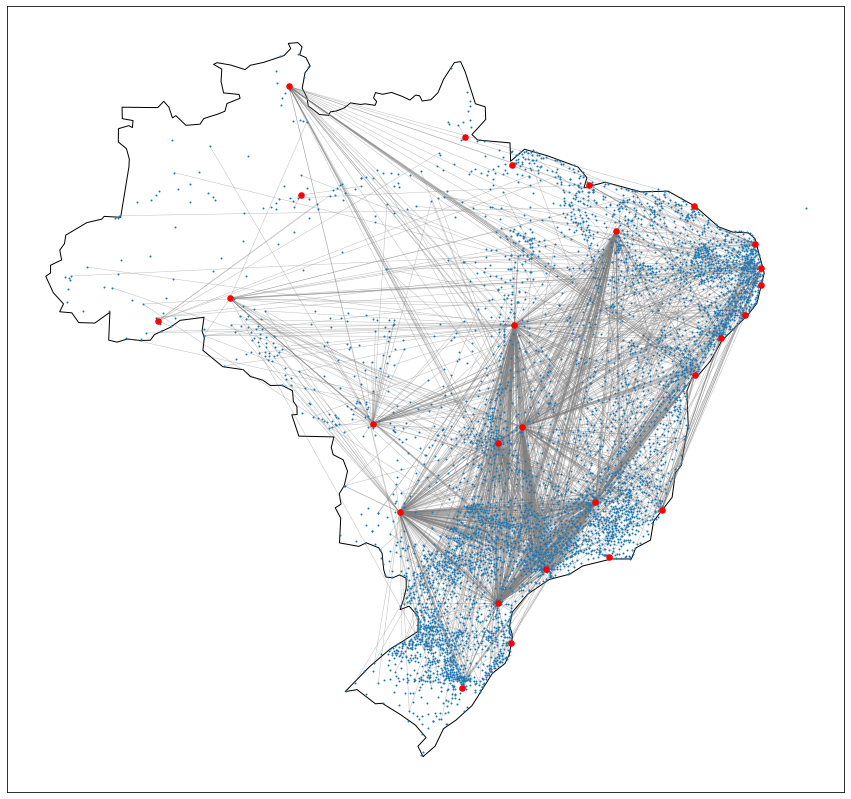

In [6]:
gdf = geopandas.GeoDataFrame()
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to Brazil.
ax = world[world.name == 'Brazil'].plot(
    color='white', edgecolor='black', figsize=(15,15))

# Plota as cidades que não são capitais
capitais = [c for c,att in G.nodes(data=True) if att['capital']==True]
nao_capitais = [c for c,att in G.nodes(data=True) if att['capital']==False]

pos = {c: (att['longitude'], att['latitude']) for c,att in G.nodes(data=True) }
nx.draw_networkx_nodes(G, pos, nao_capitais, node_size=1, ax=ax)

# Plota as capitais
nx.draw_networkx_nodes(G, pos, capitais, node_size=30, node_color='red', ax=ax)

# Plota a rede de capitais
nx.draw_networkx_edges(G, pos, G.edges(capitais), edge_color='grey', alpha=0.5, width=0.5, ax=ax)

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')
plt.show()

Cálculo da distância das cidades:

In [7]:
from math import sin, cos, atan2, sqrt, radians
def calculaDist(cid1,cid2):
  lat1 = radians(cid1[0])
  lon1 = radians(cid1[1])
  lat2 = radians(cid2[0])
  lon2 = radians(cid2[1])

  dlat = lat2-lat1
  dlon = lon2-lon1

  # Fórmula de Haversine
  R = 6373.0 # Raio da terra (km)
  a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  c = 2 * atan2(sqrt(a), sqrt(1 - a))

  dist = R*c
  return dist

Adiciona as distâncias como atributo das arestas:

In [8]:
dist = {e:calculaDist((C.nodes[e[0]]['latitude'], C.nodes[e[0]]['longitude']),
               (C.nodes[e[1]]['latitude'], C.nodes[e[1]]['longitude'])) for e in C.edges}

In [9]:
nx.set_edge_attributes(C,dist,"dist")

In [10]:
C.edges[(1100205, 2507507)]

{'dist': 3203.149547181645, 'weight': 1}

## 1.1 Distribuição de grau

In [11]:
degrees = np.array([val for (node, val) in SC_cc.degree()])
from statistics import median
print('Máximo:', degrees.max())
print('Mínimo:', degrees.min())
print('Média:',degrees.mean())
print('Mediana:', median(degrees))
print('Desvio padrão:', degrees.std())

Máximo: 5
Mínimo: 1
Média: 3.0
Mediana: 3.0
Desvio padrão: 1.3627702877384937


Capitais com maior grau:

In [12]:
x = {att['city']:val 
 for (node1, val) in SC_cc.degree()
 for (node2, att) in SC_cc.nodes(data=True)
 if node1==node2 and val!=0} 
sorted(x.items(), key=lambda item: item[1], reverse=True)

[('Brasília', 5),
 ('João Pessoa', 5),
 ('Campo Grande', 4),
 ('Salvador', 4),
 ('Curitiba', 4),
 ('Belo Horizonte', 4),
 ('São Paulo', 3),
 ('Teresina', 3),
 ('Vitória', 3),
 ('Boa Vista', 2),
 ('Maceió', 2),
 ('Goiânia', 1),
 ('Palmas', 1),
 ('Porto Velho', 1)]

Verificando o comportamento do covid nesta duas cidades: 

In [13]:
df_mun[df_mun['city']=='Brasília'].index

Int64Index([5300108], dtype='int64', name='cod')

In [14]:
df_mun[df_mun['city']=='João Pessoa'].index

Int64Index([2507507], dtype='int64', name='cod')

[]

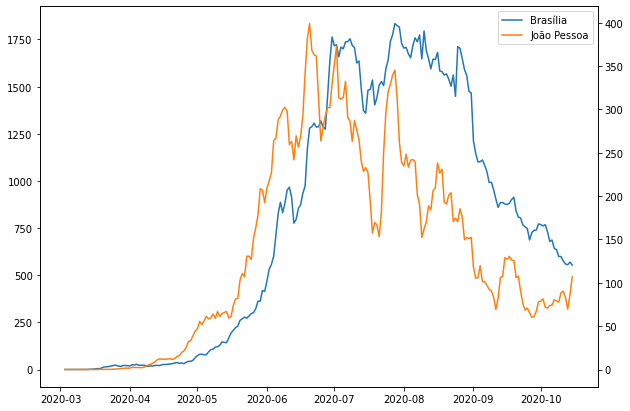

In [15]:
fig,ax1 = plt.subplots(figsize=(10,7))
l1 = ax1.plot(df_cn['5300108'], label=df_mun.loc[5300108].city)
ax2 = ax1.twinx()
l2 = ax2.plot(df_cn['2507507'], c='C1', label=df_mun.loc[2507507].city)
lns = l1+l2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
plt.plot()

## 1.2 Distribuição de Distâncias

In [16]:
length = nx.all_pairs_shortest_path_length(SC_cc)
dic_length = {c:d for c,d in length}

dic_dist = {c:{x:v[x] for x in v if x!=c}
  for c,v in dic_length.items()}

lista_dist = []
for dic in dic_dist.values():
  lista_dist = lista_dist + list(dic.values())

dist = np.array(lista_dist)

Estatísticas básicas:

In [17]:
print('Máximo:', dist.max())
print('Mínimo:', dist.min())
print('Média:',dist.mean())
print('Mediana:', median(dist))
print('Desvio padrão:', dist.std())

Máximo: 6
Mínimo: 1
Média: 2.791208791208791
Mediana: 3.0
Desvio padrão: 1.4863221332802519


Capitais com maiores distâncias entre si:

In [18]:
lista_dist2 = ([(c1,c2,d) 
  for c1, v in dic_dist.items()
  for c2, d in v.items()
  ])

In [19]:
lista_dist3 =  list(set(tuple(sorted(x)) for x in lista_dist2))

Capitais com menores distância:

In [20]:
sorted(lista_dist3)[:5]

[(1, 1100205, 2507507),
 (1, 1400100, 2927408),
 (1, 1400100, 5300108),
 (1, 1721000, 5002704),
 (1, 2211001, 3106200)]

[]

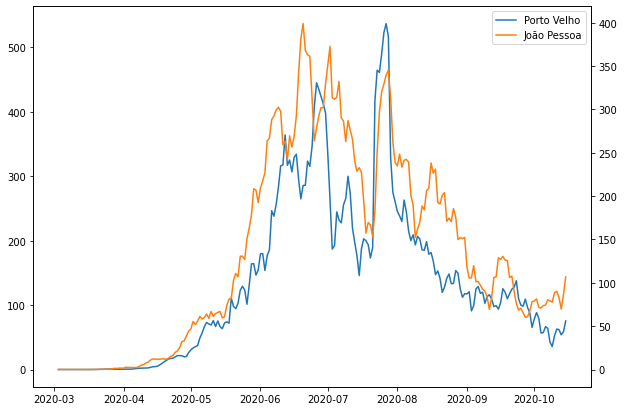

In [21]:
fig,ax1 = plt.subplots(figsize=(10,7))
l1 = ax1.plot(df_cn['1100205'], label=df_mun.loc[1100205].city)
ax2 = ax1.twinx()
l2 = ax2.plot(df_cn['2507507'], c='C1', label=df_mun.loc[2507507].city)
lns = l1+l2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
plt.plot()

Lista das 5 capitais  maiores distâncias entre si: 

In [22]:
sorted(lista_dist3,reverse=True)[:5]

[(6, 3205309, 5208707),
 (6, 2704302, 5208707),
 (6, 1721000, 3205309),
 (6, 1721000, 2704302),
 (6, 1100205, 5208707)]

Verificando o comportamento do Covid nestas cidades com maiores distância:

[]

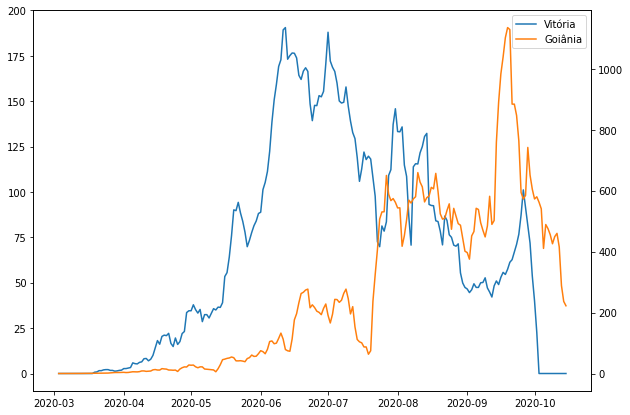

In [23]:
fig,ax1 = plt.subplots(figsize=(10,7))
l1 = ax1.plot(df_cn['3205309'], label=df_mun.loc[3205309].city)
ax2 = ax1.twinx()
l2=ax2.plot(df_cn['5208707'], c='C1', label=df_mun.loc[5208707].city)
lns = l1+l2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
plt.plot()

#2 Análise da componente conexa gigante

## 2.0 Visualização

/usr/local/lib/python3.6/dist-packages/geopandas/plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


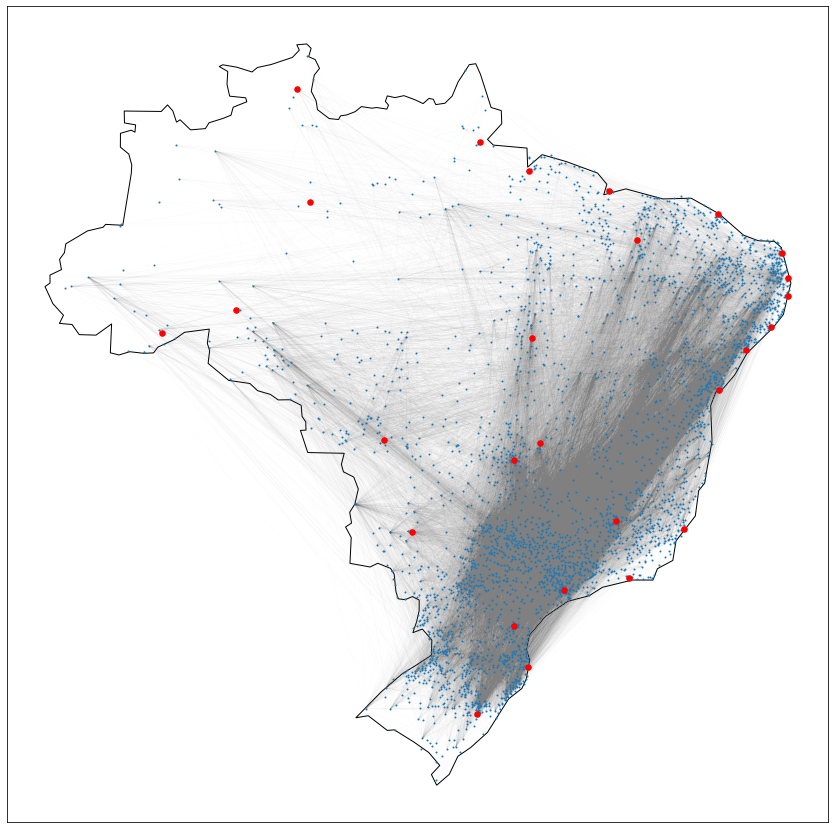

In [24]:
gdf = geopandas.GeoDataFrame()
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# Prepara o geopandaas para plotar o mapa do Brasil
ax = world[world.name == 'Brazil'].plot(
    color='white', edgecolor='black', figsize=(15,15))

pos = {c: (att['longitude'], att['latitude']) for c,att in G.nodes(data=True) }

# Plota a rede
# nx.draw_networkx(S, pos, node_size=1, edge_color='grey', alpha=0.1, width=0.5, with_labels=False, ax=ax)
nx.draw_networkx_edges(S, pos, S.edges, edge_color='grey', alpha=0.1, width=0.1, ax=ax)
nx.draw_networkx_nodes(S, pos, node_size=1, ax=ax)
nx.draw_networkx_nodes(G, pos, capitais, node_size=30, node_color='red', ax=ax) # capitais

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')
plt.show()

## 2.1 Distribuição de grau

### 2.1.1 Estatísticas básicas

In [25]:
degrees = np.array([val for (node, val) in S.degree()])
from statistics import median
print('Máximo:', degrees.max())
print('Mínimo:', degrees.min())
print('Média:',degrees.mean())
print('Mediana:', median(degrees))
print('Desvio padrão:', degrees.std())

Máximo: 293
Mínimo: 1
Média: 28.501483679525222
Mediana: 11.0
Desvio padrão: 41.15215485768324


### 2.1.1 PMF empírica

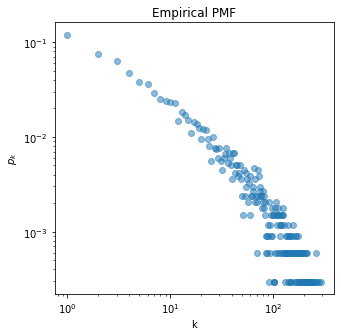

In [26]:
x, f = np.unique(degrees, return_counts=True)
pmf = f/f.sum()

plt.figure(figsize=(5,5))
plt.scatter(x,pmf,alpha=0.5)
plt.title('Empirical PMF')
plt.xlabel('k')
plt.ylabel('$p_k$')
plt.xscale('log')
plt.yscale('log')
plt.show()

### 2.1.2 CCDF empírica

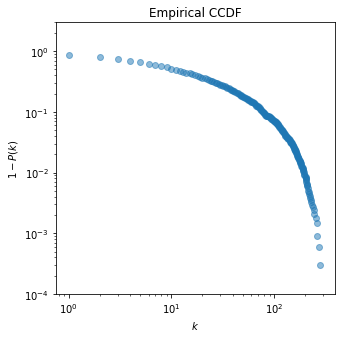

In [27]:
cdf = f.cumsum()/f.sum()
ccdf = 1-cdf

plt.figure(figsize=(5,5))
plt.scatter(x,ccdf,alpha=0.5)
plt.title('Empirical CCDF')
plt.xlabel('$k$')
plt.ylabel('$1-P(k)$')
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**-4, 3*10**0)
plt.show()

Verificamos que a distribuição não segue é uma lei de potência.

### 2.1.3 Outras análises

Top 10 cidades com maior grau:

In [28]:
x = {att['city']:val 
 for (node1, val) in S.degree()
 for (node2, att) in S.nodes(data=True)
 if node1==node2 and val>0} 
sorted(x.items(), key=lambda item: item[1], reverse=True)[:10]

[('São José do Rio Preto', 293),
 ('Barreiras', 281),
 ("Santa Bárbara d'Oeste", 270),
 ('Americana', 261),
 ('Santa Rosa', 261),
 ('Campina Grande do Sul', 259),
 ('Vinhedo', 253),
 ('Valinhos', 246),
 ('Atibaia', 245),
 ('São José dos Campos', 240)]

## 2.2 Distribuição de distâncias

In [29]:
length = nx.all_pairs_shortest_path_length(S)
dic_length = {c:d for c,d in length}
dic_dist = {c:{x:v[x] for x in v if x!=c}
  for c,v in dic_length.items()}
lista_dist = []
for dic in dic_dist.values():
  lista_dist = lista_dist + list(dic.values())
dist = np.array(lista_dist)

### 2.2.1 Estatísticas básicas

In [30]:
print('Máximo:', dist.max())
print('Mínimo:', dist.min())
print('Média:',dist.mean())
print('Mediana:', median(dist))
print('Desvio padrão:', dist.std())

Máximo: 18
Mínimo: 1
Média: 4.9948697893958975
Mediana: 5.0
Desvio padrão: 2.0870970627922163


### 2.2.2 PMF empírica

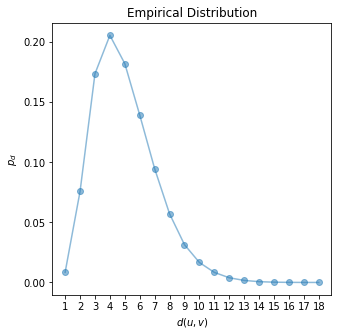

In [31]:
x, f_d = np.unique(dist, return_counts=True)
pmf = f_d/f_d.sum()

plt.figure(figsize=(5,5))
plt.title('Empirical Distribution')
plt.xlabel('$d(u,v)$')
plt.ylabel('$p_d$')
plt.xticks(range(0,20))
plt.scatter(x,pmf,alpha=0.5)
plt.plot(x,pmf, alpha=0.5)
plt.show()

### 2.2.3 Distância na rede x Distância física

In [106]:
dr_df = [(dic_dist[u][v], calculaDist((S.nodes[u]['latitude'], S.nodes[u]['longitude']),(S.nodes[v]['latitude'], S.nodes[v]['longitude']))/1000)
 for u, v, j in jaccard]

In [107]:
dr = np.array([dr for dr,_ in dr_df])
df = np.array([df for _,df in dr_df])

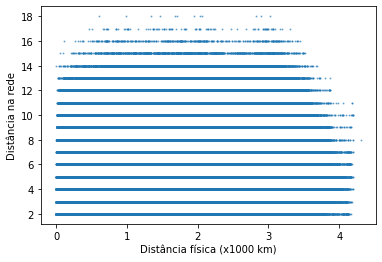

In [109]:
plt.scatter(df,dr, s=1, alpha=0.5)
plt.xlabel('Distância física (x1000 km)')
plt.ylabel('Distância na rede')
plt.show()

In [121]:
np.corrcoef(df,dr)

array([[1.        , 0.16996172],
       [0.16996172, 1.        ]])

In [114]:
dr_df2 = [(dic_dist[u][v], calculaDist((S.nodes[u]['latitude'], S.nodes[u]['longitude']),(S.nodes[v]['latitude'], S.nodes[v]['longitude']))/1000)
 for u, v, j in jaccard
 if calculaDist((S.nodes[u]['latitude'], S.nodes[u]['longitude']),(S.nodes[v]['latitude'], S.nodes[v]['longitude']))/1000 < 0.1]

In [ ]:
dr2 = np.array([dr for dr,_ in dr_df2])
df2 = np.array([df for _,df in dr_df2])

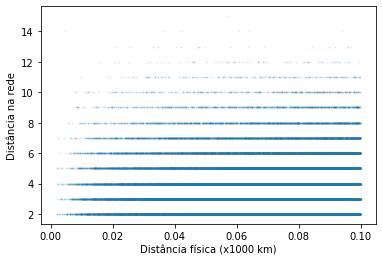

In [127]:
plt.scatter(df2,dr2, s=1, alpha=0.1)
plt.xlabel('Distância física (x1000 km)')
plt.ylabel('Distância na rede')
plt.show()

In [125]:
np.corrcoef(df2,dr2)

array([[1.        , 0.07064088],
       [0.07064088, 1.        ]])

In [122]:
dr_df3 = [(dic_dist[u][v], calculaDist((S.nodes[u]['latitude'], S.nodes[u]['longitude']),(S.nodes[v]['latitude'], S.nodes[v]['longitude']))/1000)
 for u, v, j in jaccard
 if calculaDist((S.nodes[u]['latitude'], S.nodes[u]['longitude']),(S.nodes[v]['latitude'], S.nodes[v]['longitude']))/1000 > 3]

In [123]:
dr3 = np.array([dr for dr,_ in dr_df3])
df3 = np.array([df for _,df in dr_df3])

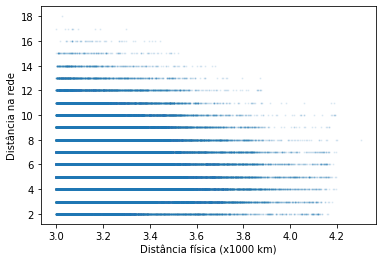

In [128]:
plt.scatter(df3,dr3, s=1, alpha=0.1)
plt.xlabel('Distância física (x1000 km)')
plt.ylabel('Distância na rede')
plt.show()

In [126]:
np.corrcoef(df3,dr3)

array([[ 1.        , -0.08622219],
       [-0.08622219,  1.        ]])

## 2.3 Assortatividade

In [32]:
df_mun

,regiao,uf,city,capital,population,idhf,pib,latitude,longitude,porte_pop,porte_idh,porte_pib
cod,,,,,,,,,,,,
1100015,Norte,RO,Alta Floresta D'Oeste,False,22728,0.609139,19611.75,-11.92830,-61.9953,3,2,2
1100023,Norte,RO,Ariquemes,False,109523,0.753049,21389.67,-9.90571,-63.0325,6,3,2
1100031,Norte,RO,Cabixi,False,5188,0.591030,22315.80,-13.49450,-60.5520,2,2,2
1100049,Norte,RO,Cacoal,False,85893,0.748255,24037.91,-11.43430,-61.4562,5,3,2
1100056,Norte,RO,Cerejeiras,False,16204,0.663645,25009.71,-13.18700,-60.8168,3,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
5222005,Centro-oeste,GO,Vianópolis,False,13977,0.677555,28942.36,-16.74050,-48.5159,3,2,2
5222054,Centro-oeste,GO,Vicentinópolis,False,8873,0.664198,41772.71,-17.73220,-49.8047,2,2,2
5222203,Centro-oeste,GO,Vila Boa,False,6312,0.321381,23992.38,-15.03870,-47.0520,2,1,2


Critério de Cohen para estudos sociais:
- $0.1 \leq r < 0.3$: baixa
- $0.3 \leq r < 0.5$: média
- $r \geq 0.5$: alta

Fonte: https://en.wikipedia.org/wiki/Effect_size

### 2.3.1 Assortatividade de grau

In [33]:
nx.degree_assortativity_coefficient(S)

0.31981102767524144

**Interpretação**: correlação positiva: *hubs* tendem a se conectar com hubs

### 2.3.2 Atributos categóricos 

#### Regiões

- Assortatividade:

In [34]:
print(nx.attribute_assortativity_coefficient(S, "regiao"))

0.16779333504527297


- Matriz de mixagem:

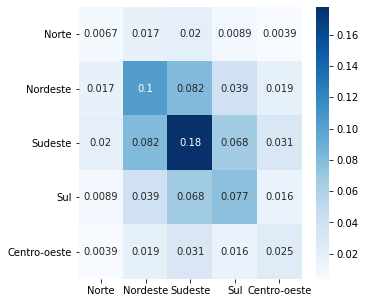

In [35]:
fig, axs = plt.subplots(figsize=(5,5))
sns.heatmap(pd.DataFrame.from_dict({reg:dict for reg,dict in nx.attribute_mixing_dict(S, "regiao", normalized=True).items()
}), cmap=plt.cm.Blues, annot=True)
plt.yticks(rotation=0)
plt.show()

- Regiões que "mais se misturam": **Sudeste** x **Nordeste**, **Sudeste** x **Sul**
- Regiões que "menos se misturam": **Centro-Oeste** x **Norte**, **Centro-Oeste** x **Sul**

Número de municípios por região:

In [36]:
regioes = ['Centro-oeste', 'Nordeste', 'Norte', 'Sudeste', 'Sul']
sorted({r:len([c for c in S.nodes 
        if S.nodes[c]['regiao']==r])
  for r in regioes}.items(), key=lambda tup: tup[1], reverse=True)

[('Nordeste', 1086),
 ('Sudeste', 1005),
 ('Sul', 695),
 ('Centro-oeste', 323),
 ('Norte', 261)]

População por região:

In [37]:
regioes = ['Centro-oeste', 'Nordeste', 'Norte', 'Sudeste', 'Sul']
sorted({r:sum([S.nodes[c]['population'] 
        for c in S.nodes
        if S.nodes[c]['regiao']==r])/1000000
  for r in regioes}.items(), key=lambda tup: tup[1], reverse=True)

[('Sudeste', 70.280857),
 ('Nordeste', 46.025932),
 ('Sul', 23.891008),
 ('Centro-oeste', 14.743904),
 ('Norte', 11.724091)]

#### Estado

In [38]:
print(nx.attribute_assortativity_coefficient(S, "uf"))

0.14540150664163032


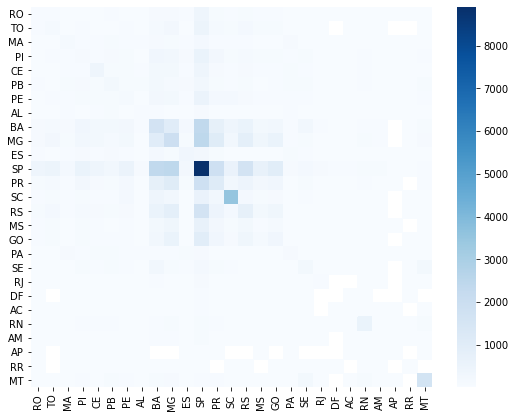

In [132]:
fig, axs = plt.subplots(figsize=(9,7))
sns.heatmap(pd.DataFrame.from_dict(nx.attribute_mixing_dict(S, "uf")), cmap=plt.cm.Blues, annot=False)
plt.yticks(rotation=0)
plt.show()

- Normalizar pelo número de cidades

Número de municípios por estado:

In [40]:
estados = pd.unique(df_mun['uf'])
sorted({uf:len([c for c in S.nodes 
        if S.nodes[c]['uf']==uf])
  for uf in estados}.items(), key=lambda tup: tup[1], reverse=True)

[('SP', 460),
 ('MG', 437),
 ('BA', 293),
 ('RS', 249),
 ('PR', 233),
 ('SC', 213),
 ('GO', 145),
 ('CE', 126),
 ('PB', 123),
 ('MT', 121),
 ('PE', 117),
 ('PI', 115),
 ('MA', 106),
 ('RN', 97),
 ('TO', 94),
 ('PA', 77),
 ('ES', 65),
 ('SE', 59),
 ('MS', 56),
 ('AL', 50),
 ('RJ', 43),
 ('RO', 34),
 ('AM', 23),
 ('AC', 13),
 ('AP', 12),
 ('RR', 8),
 ('DF', 1)]

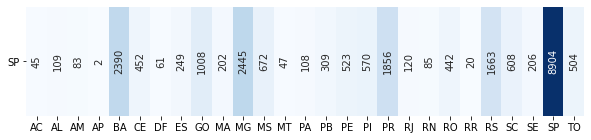

In [41]:
fig, axs = plt.subplots(figsize=(10,2))
sns.heatmap(pd.DataFrame.from_dict({reg:dict for reg,dict in nx.attribute_mixing_dict(S, "uf").items()
if any(np.fromiter(dict.values(), dtype=float) >5000)}).transpose(), cmap=plt.cm.Blues, annot=True, annot_kws={'rotation':90}, fmt='.0f', cbar=False)
plt.yticks(rotation=0)
plt.show()

#### Capital

In [42]:
print(nx.attribute_assortativity_coefficient(S, "capital"))

0.009734847257727686


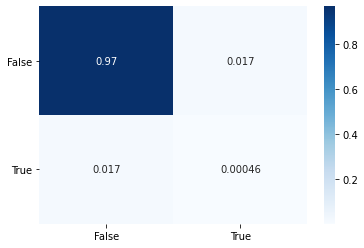

In [43]:
sns.heatmap(pd.DataFrame.from_dict(nx.attribute_mixing_dict(S, "capital", normalized=True)), cmap=plt.cm.Blues, annot=True)
plt.yticks(rotation=0)
plt.show()

### 2.3.3 Atributos ordinários

#### População

Faixas populacionais ($\times1000$ habitantes):
- 1: $\leq 5$
- 2: $(5, 10]$
- 3: $(10, 25]$
- 4: $(25, 50]$ 
- 5: $(50, 100]$ 
- 6: $(100, 500]$ 
- 7: $>500$  

Número de municípios por faixa populacional:

In [44]:
{porte:len([c for c in S.nodes 
        if S.nodes[c]['porte_pop']==porte])
  for porte in range(1,8)}

{1: 548, 2: 617, 3: 1059, 4: 571, 5: 292, 6: 239, 7: 44}

In [45]:
print(nx.numeric_assortativity_coefficient(S, "porte_pop"))

0.26260982548192535


- Cidades com tamanho parecido possuem dinâmica da evolção da Covid parecida
- Existe correlação entre tamanho população e dinâmica do Covid

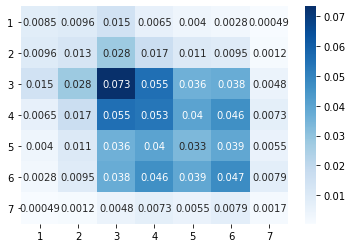

In [46]:
sns.heatmap(pd.DataFrame(nx.numeric_mixing_matrix(S, "porte_pop")[1:,1:], index=range(1,8), columns=range(1,8)), cmap=plt.cm.Blues, annot=True)
plt.yticks(rotation=0)
plt.show()

- Normalizar pelo número total de arestas que poderiam existir

- A maior parte das cidades possuem  população na faixa 3;
- As faixas centrais são as que mais se misturam;
- As cidades com faixas extremas de população não se misturam;
- Isso explica porque as capitais não representam bem a dinâmica média da Covid-19 no Brasil como um todo;
- Inclusive o município do Rio de Janeiro nem faz parte da GCC.

#### IDH

Faixas de IDH:
- 1: $\leq 0.555$ (baixo)
- 2: $[0.555, 0.700)$ (médio)
- 3: $[0.700, 0.800)$ (alto)
- 4: $>0.800$ (muito alto)

Número de municípios por faixa de IDH:

In [47]:
{porte:len([c for c in S.nodes 
        if S.nodes[c]['porte_idh']==porte])
  for porte in range(1,5)}

{1: 456, 2: 1492, 3: 1077, 4: 345}

In [48]:
print(nx.numeric_assortativity_coefficient(S, "porte_idh"))

0.18378721118172467


- Hipótese: Acreditamos que este valor seria bem maior se eliminássemos o fator temporal;
- Interessante para estudo futuro;

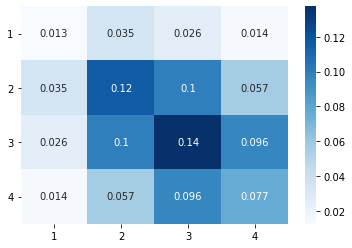

In [49]:
sns.heatmap(pd.DataFrame(nx.numeric_mixing_matrix(S, "porte_idh")[1:, 1:], index=range(1,5), columns=range(1,5)), cmap=plt.cm.Blues, annot=True)
plt.yticks(rotation=0)
plt.show()

- Cidades com IDH mais alto número são mais confiáveis

In [50]:
0.035+0.12+0.1+0.057

0.312

In [51]:
0.026+0.1+0.14+0.096

0.362

- No geral, baixa assortatividade para as faixas isoladas de IDH. Porém:
- Cidades com IDH próximo tendem a se agrupar mais;
- Maior homofilia entre as cidades com IDH alto(3) e muito alto (4) do que IDH médio (2) ou baixo (1);
- Apesar da maioria dos municípios possuírem IDH médio (2),maior parte das arestas são entre cidades com IDH alto (3), ou seja, elas possuem dinâmica mais característica.

#### PIB per capita do município

Faixas de PIB per capita ($\times$ mil R\$ / ano):
- 1: $\leq 10$
- 2: $(10, 50]$
- 3: $(50, 100]$
- 4: $(100, 200]$
- 5: $>200$

Número de municípios por faixa:

In [52]:
{porte:len([c for c in S.nodes 
        if S.nodes[c]['porte_pib']==porte])
  for porte in range(1,6)}

{1: 824, 2: 2304, 3: 200, 4: 32, 5: 10}

In [53]:
print(nx.numeric_assortativity_coefficient(S, "porte_pib"))

0.07802965288683207


- PIB per capita pouco influencia os relacinamentos (similaridade entre a dinâmica da epidemia)

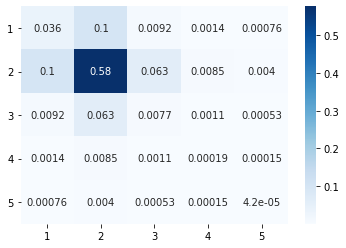

In [54]:
sns.heatmap(pd.DataFrame(nx.numeric_mixing_matrix(S, "porte_pib")[1:, 1:], index=range(1,6), columns=range(1,6)), cmap=plt.cm.Blues, annot=True)
plt.yticks(rotation=0)
plt.show()

### 2.3.4 Outras análises

Correlação IDH x PIB per capita:

In [55]:
df_mun[['porte_idh', 'porte_pib']].corr()

,porte_idh,porte_pib
porte_idh,1.000000,0.509861
porte_pib,0.509861,1.000000


Top 5 municípios com maior IDH:

In [56]:
sorted({(S.nodes[cid]['city'], S.nodes[cid]['uf']):S.nodes[cid]['idhf']
     for cid in S.nodes
     }.items(), key=lambda tup: tup[1], reverse=True)[:5]

[(('Louveira', 'SP'), 0.900623),
 (('Olímpia', 'SP'), 0.88195),
 (('Vale Real', 'RS'), 0.8807159999999999),
 (('Apucarana', 'PR'), 0.8805629999999999),
 (('Toledo', 'PR'), 0.878582)]

Top 5 municípios com maior PIB per capita:

In [57]:
sorted({(S.nodes[cid]['city'], S.nodes[cid]['uf']):S.nodes[cid]['pib']
     for cid in S.nodes
     }.items(), key=lambda tup: tup[1], reverse=True)[:5]

[(('Paulínia', 'SP'), 344847.17),
 (('Triunfo', 'RS'), 311211.93),
 (('Louveira', 'SP'), 300639.4),
 (('Presidente Kennedy', 'ES'), 292397.08),
 (('São Gonçalo do Rio Abaixo', 'MG'), 289925.44)]

## 2.4 Similaridade

### 2.4.1 Similaridade de Jaccard

#### Distribuição

In [58]:
jaccard = [(u, v, j) for (u, v, j) in nx.jaccard_coefficient(S)]

In [59]:
j_coef = np.array([j for (u, v, j) in jaccard])
print('Máximo:', j_coef.max())
print('Mínimo:', j_coef.min())
print('Média:', j_coef.mean())
print('Mediana:', median(j_coef))
print('Desvio padrão:', j_coef.std())

Máximo: 1.0
Mínimo: 0.0
Média: 0.00403843112819026
Mediana: 0.0
Desvio padrão: 0.02047367755452844


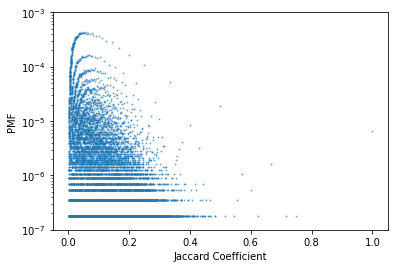

In [60]:
x, f = np.unique(j_coef, return_counts=True)
pmf = f/f.sum()
plt.scatter(x,pmf, alpha=0.5, s=1)
plt.xlabel('Jaccard Coefficient')
plt.ylabel('PMF')
plt.yscale('log')
plt.ylim(10**-7, 10**-3)
plt.show()

#### Cidades mais semelhantes

In [129]:
sorted([(str(S.nodes[u]['city']) + "-" + str(S.nodes[u]['uf']), u, 
         str(S.nodes[v]['city']) + "-" + str(S.nodes[v]['uf']), v, 
         j, calculaDist((S.nodes[u]['latitude'], S.nodes[u]['longitude']),(S.nodes[v]['latitude'], S.nodes[v]['longitude']))/1000 ) 
  for u, v, j in jaccard
  if j > 0.7], key=lambda tup: tup[4])[:5]

[('Aracitaba-MG',
  3103306,
  'Mucajaí-RR',
  1400308,
  0.7142857142857143,
  3.2622408296903767),
 ('Pedra Preta-RN',
  2409605,
  'São José do Jacuri-MG',
  3163508,
  0.75,
  1.582977461528255),
 ('Barro-CE',
  2302008,
  'Jenipapo dos Vieiras-MA',
  2105476,
  1.0,
  0.7848507692230855),
 ('Unaí-MG', 3170404, 'Fernando Prestes-SP', 3515608, 1.0, 0.5772262462906526),
 ('Abaré-BA', 2900207, 'Isaías Coelho-PI', 2204907, 1.0, 0.3020743456090593)]

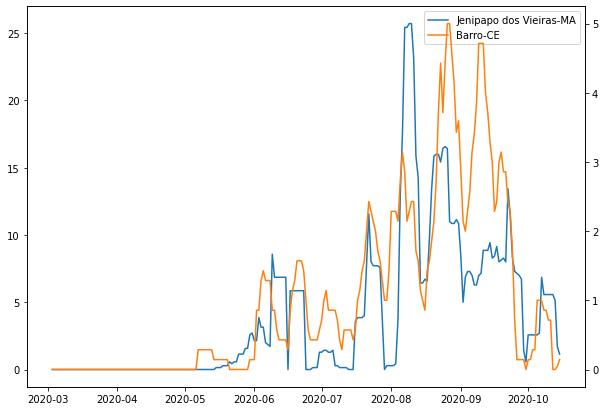

In [133]:
fig,ax1 = plt.subplots(figsize=(10,7))
l1 = ax1.plot(df_cn['2105476'], label='Jenipapo dos Vieiras-MA')
ax2 = ax1.twinx()
l2=ax2.plot(df_cn['2302008'], c='C1', label='Barro-CE')
lns = l1+l2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
plt.show()

/usr/local/lib/python3.6/dist-packages/geopandas/plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


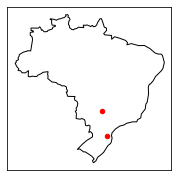

In [62]:
# We restrict to Brazil.
ax = world[world.name == 'Brazil'].plot(
    color='white', edgecolor='black', figsize=(3,3))

# Plota as cidades que não são capitais
C = nx.subgraph(S, [4219408, 3544509])

nx.draw_networkx_nodes(S, pos, C, node_size=20, ax=ax, node_color='red')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')
plt.show()

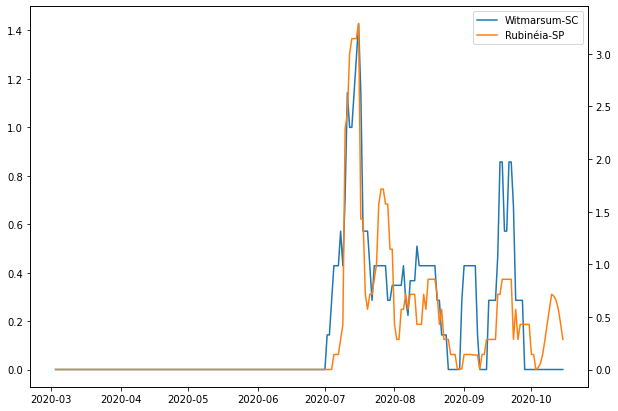

In [63]:
fig,ax1 = plt.subplots(figsize=(10,7))
l1 = ax1.plot(df_cn['4219408'], label='Witmarsum-SC')
ax2 = ax1.twinx()
l2=ax2.plot(df_cn['3544509'], c='C1', label='Rubinéia-SP')
lns = l1+l2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
plt.show()

#### Cidades menos semelhantes

In [64]:
sorted([(S.nodes[u]['city'], S.nodes[u]['uf'], u, S.nodes[v]['city'], S.nodes[v]['uf'], v, j) 
  for u, v, j in jaccard
  if j < 0.3], key=lambda tup: tup[6])[10]

('Antônio Prado', 'RS', 4300802, 'Esperantina', 'PI', 2203701, 0.0)

/usr/local/lib/python3.6/dist-packages/geopandas/plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


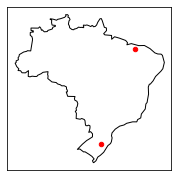

In [65]:
# We restrict to Brazil.
ax = world[world.name == 'Brazil'].plot(
    color='white', edgecolor='black', figsize=(3,3))

# Plota as cidades que não são capitais
C = nx.subgraph(S, [4300802, 2203701])

nx.draw_networkx_nodes(S, pos, C, node_size=20, ax=ax, node_color='red')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')
plt.show()

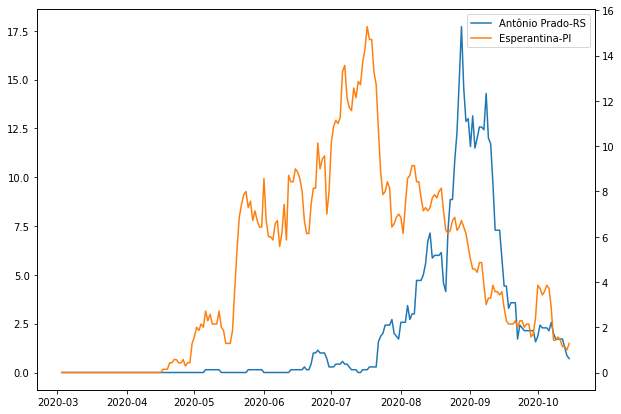

In [66]:
fig,ax1 = plt.subplots(figsize=(10,7))
l1 = ax1.plot(df_cn['4300802'], label='Antônio Prado-RS')
ax2 = ax1.twinx()
l2=ax2.plot(df_cn['2203701'], c='C1', label='Esperantina-PI')
lns = l1+l2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
plt.show()

#### Semelhança x distância física

In [90]:
j_df = [(j, calculaDist((S.nodes[u]['latitude'], S.nodes[u]['longitude']),(S.nodes[v]['latitude'], S.nodes[v]['longitude']))/1000)
 for u, v, j in jaccard]

In [93]:
j = np.array([j for j,_ in j_df])
d = np.array([d for _,d in j_df])

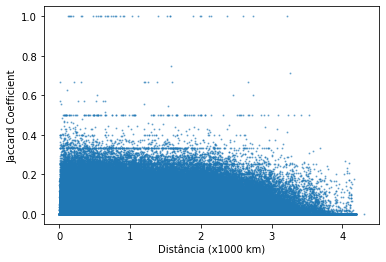

In [101]:
plt.scatter(d,j, s=1, alpha=0.5)
plt.xlabel('Distância (x1000 km)')
plt.ylabel('Jaccard Coefficient')
plt.show()

In [97]:
np.corrcoef(d, j)

array([[ 1.        , -0.06052008],
       [-0.06052008,  1.        ]])

## 2.5 Detecção de Comunidades

Algoritmo de Girvan-Newman

In [67]:
#import itertools
#k = 4
#comp = nx.community.girvan_newman(S)
#limited = itertools.takewhile(lambda c: len(c) <= k, comp)
#comunidades1 = [c for c in next(comp)]